* Initial_submition_ver to new SAN/AVN data (without CCS cells)

## Import modules

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scnym.api import scnym_api

In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu',)

## Function

In [4]:
# from https://github.com/Teichlab/sctk/blob/ec686e2a542777bf1a39923d427f9df7acef6022/sctk/_utils.py#L1156

def subsample(adata, fraction, groupby=None, min_n=0, max_n=10000, method='random', index_only=False, random_state=0):
    if method not in ('random', 'top'):
        raise NotImplementedError(f'method={method} unsupported')
    if groupby:
        if groupby not in adata.obs.columns:
            raise KeyError(f'{groupby} is not a valid obs annotation.')
        groups = adata.obs[groupby].unique()
        n_obs_per_group = {}
        sampled_obs_names = []
        for grp in groups:
            k = adata.obs[groupby] == grp
            grp_size = sum(k)
            ds_grp_size = int(min(
                max_n, max(np.ceil(grp_size * fraction), min(min_n, grp_size))))
            if method == 'top':
                idx = np.argsort(-adata.obs.loc[k, 'n_counts'].values)[0:ds_grp_size]
            else:
                np.random.seed(random_state)
                idx = np.random.choice(grp_size, ds_grp_size, replace=False)
            sampled_obs_names.extend(list(adata.obs_names[k][idx]))
    else:
        ds_size = int(adata.n_obs * fraction)
        np.random.seed(random_state)
        idx = np.random.choice(adata.n_obs, ds_size, replace=False)
        sampled_obs_names = adata.obs_names[idx]

    if index_only:
        return sampled_obs_names
    else:
        return adata[adata.obs_names.isin(sampled_obs_names)].copy()

## Read in reference data

In [5]:
# original adata
ref = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_cellstate-annotated.h5ad')

# rename cell_states
ref.obs.replace({'cell_state':{
    'FB4':'FB4_activated',
    'vCM3':'vCM3_stressed',
    'NC1':'NC1_glial',
    'NC2':'NC2_glial_NGF+',
    'NC3':'NC3_glial',
    'NC4':'NC4_glial',
    'NC5':'NC5_glial',
    'NC6':'NC6_schwann',
    'EC7_atria':'EC7_endocardial',
}},inplace=True)

ref.obs['cell_state']=ref.obs['cell_state'].astype('category')
ref.obs['cell_state'].cat.reorder_categories([
    'SAN_P_cell','AVN_P_cell','AVN_bundle_cell',
    'aCM1','aCM2', 'aCM3', 'aCM4', 'aCM5', 
    'vCM1', 'vCM2','vCM3_stressed', 'vCM4', 'vCM5', 
     'EC1_cap','EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven','EC7_endocardial',
       'EC8_ln', 'EC9_FB-like', 'EC10_CMC-like', 
    'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 'SMC1_basic', 'SMC2_art',
    'FB1', 'FB2', 'FB3', 'FB4_activated','FB5', 'FB6',
    'Meso',
    'Adip1', 'Adip2', 'Adip3', 'Adip4',
   'NC1_glial','NC2_glial_NGF+', 'NC3_glial', 'NC4_glial', 'NC5_glial','NC6_schwann',
    'CD4+T_naive', 'CD4+T_act','CD4+T_Th1', 'CD4+T_Th2', 'CD4+T_Th17', 'CD4+T_Tfh',
       'CD4+T_reg', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans','MAIT-like','gdT', 
    'NK_CD16hi', 'NK_CD56hi', 'ILC', 
     'B', 'B_plasma', 
    'CD14+Mo',  'CD16+Mo', 'MoMP',
    'LYVE1+IGF1+MP','LYVE1+TIMD4+MP', 'LYVE1+MP_cycling','DC','Neut','Mast',
    'T/NK_cycling', 'unclassified', 
     ], inplace=True)

# remove unclassified
ref = ref[ref.obs['cell_state']!='unclassified']

##### remove CCS cells #####
ref = ref[ref.obs['cell_state'].isin(['SAN_P_cell','AVN_P_cell','AVN_bundle_cell'])==False]

ref

View of AnnData object with n_obs × n_vars = 620366 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [7]:
ref.obs['cell_state'].cat.categories

Index(['aCM1', 'aCM2', 'aCM3', 'aCM4', 'aCM5', 'vCM1', 'vCM2', 'vCM3_stressed',
       'vCM4', 'vCM5', 'EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune',
       'EC5_art', 'EC6_ven', 'EC7_endocardial', 'EC8_ln', 'EC9_FB-like',
       'EC10_CMC-like', 'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like',
       'SMC1_basic', 'SMC2_art', 'FB1', 'FB2', 'FB3', 'FB4_activated', 'FB5',
       'FB6', 'Meso', 'Adip1', 'Adip2', 'Adip3', 'Adip4', 'NC1_glial',
       'NC2_glial_NGF+', 'NC3_glial', 'NC4_glial', 'NC5_glial', 'NC6_schwann',
       'CD4+T_naive', 'CD4+T_act', 'CD4+T_Th1', 'CD4+T_Th2', 'CD4+T_Th17',
       'CD4+T_Tfh', 'CD4+T_reg', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te',
       'CD8+T_trans', 'MAIT-like', 'gdT', 'NK_CD16hi', 'NK_CD56hi', 'ILC', 'B',
       'B_plasma', 'CD14+Mo', 'CD16+Mo', 'MoMP', 'LYVE1+IGF1+MP',
       'LYVE1+TIMD4+MP', 'LYVE1+MP_cycling', 'DC', 'Neut', 'Mast',
       'T/NK_cycling'],
      dtype='object')

In [8]:
sc.pp.filter_genes(ref, min_cells=3)
sc.pp.normalize_total(ref, target_sum=1e4)
sc.pp.log1p(ref)
ref

filtered out 1627 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


normalizing counts per cell
    finished (0:00:04)


AnnData object with n_obs × n_vars = 620366 × 31105
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2', 'n_cells'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors', 'log1p'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [9]:
# downsize for training
ref = subsample(ref, fraction=1, groupby='cell_state', min_n=0, max_n=2000, method='random', index_only=False, random_state=0)
ref.obs['cell_state'].value_counts()

aCM1           2000
FB6            2000
EC2_cap        2000
CD4+T_naive    2000
EC3_cap        2000
               ... 
gdT              21
NC3_glial        20
NC6_schwann      18
NC4_glial        13
CD4+T_Th17        7
Name: cell_state, Length: 71, dtype: int64

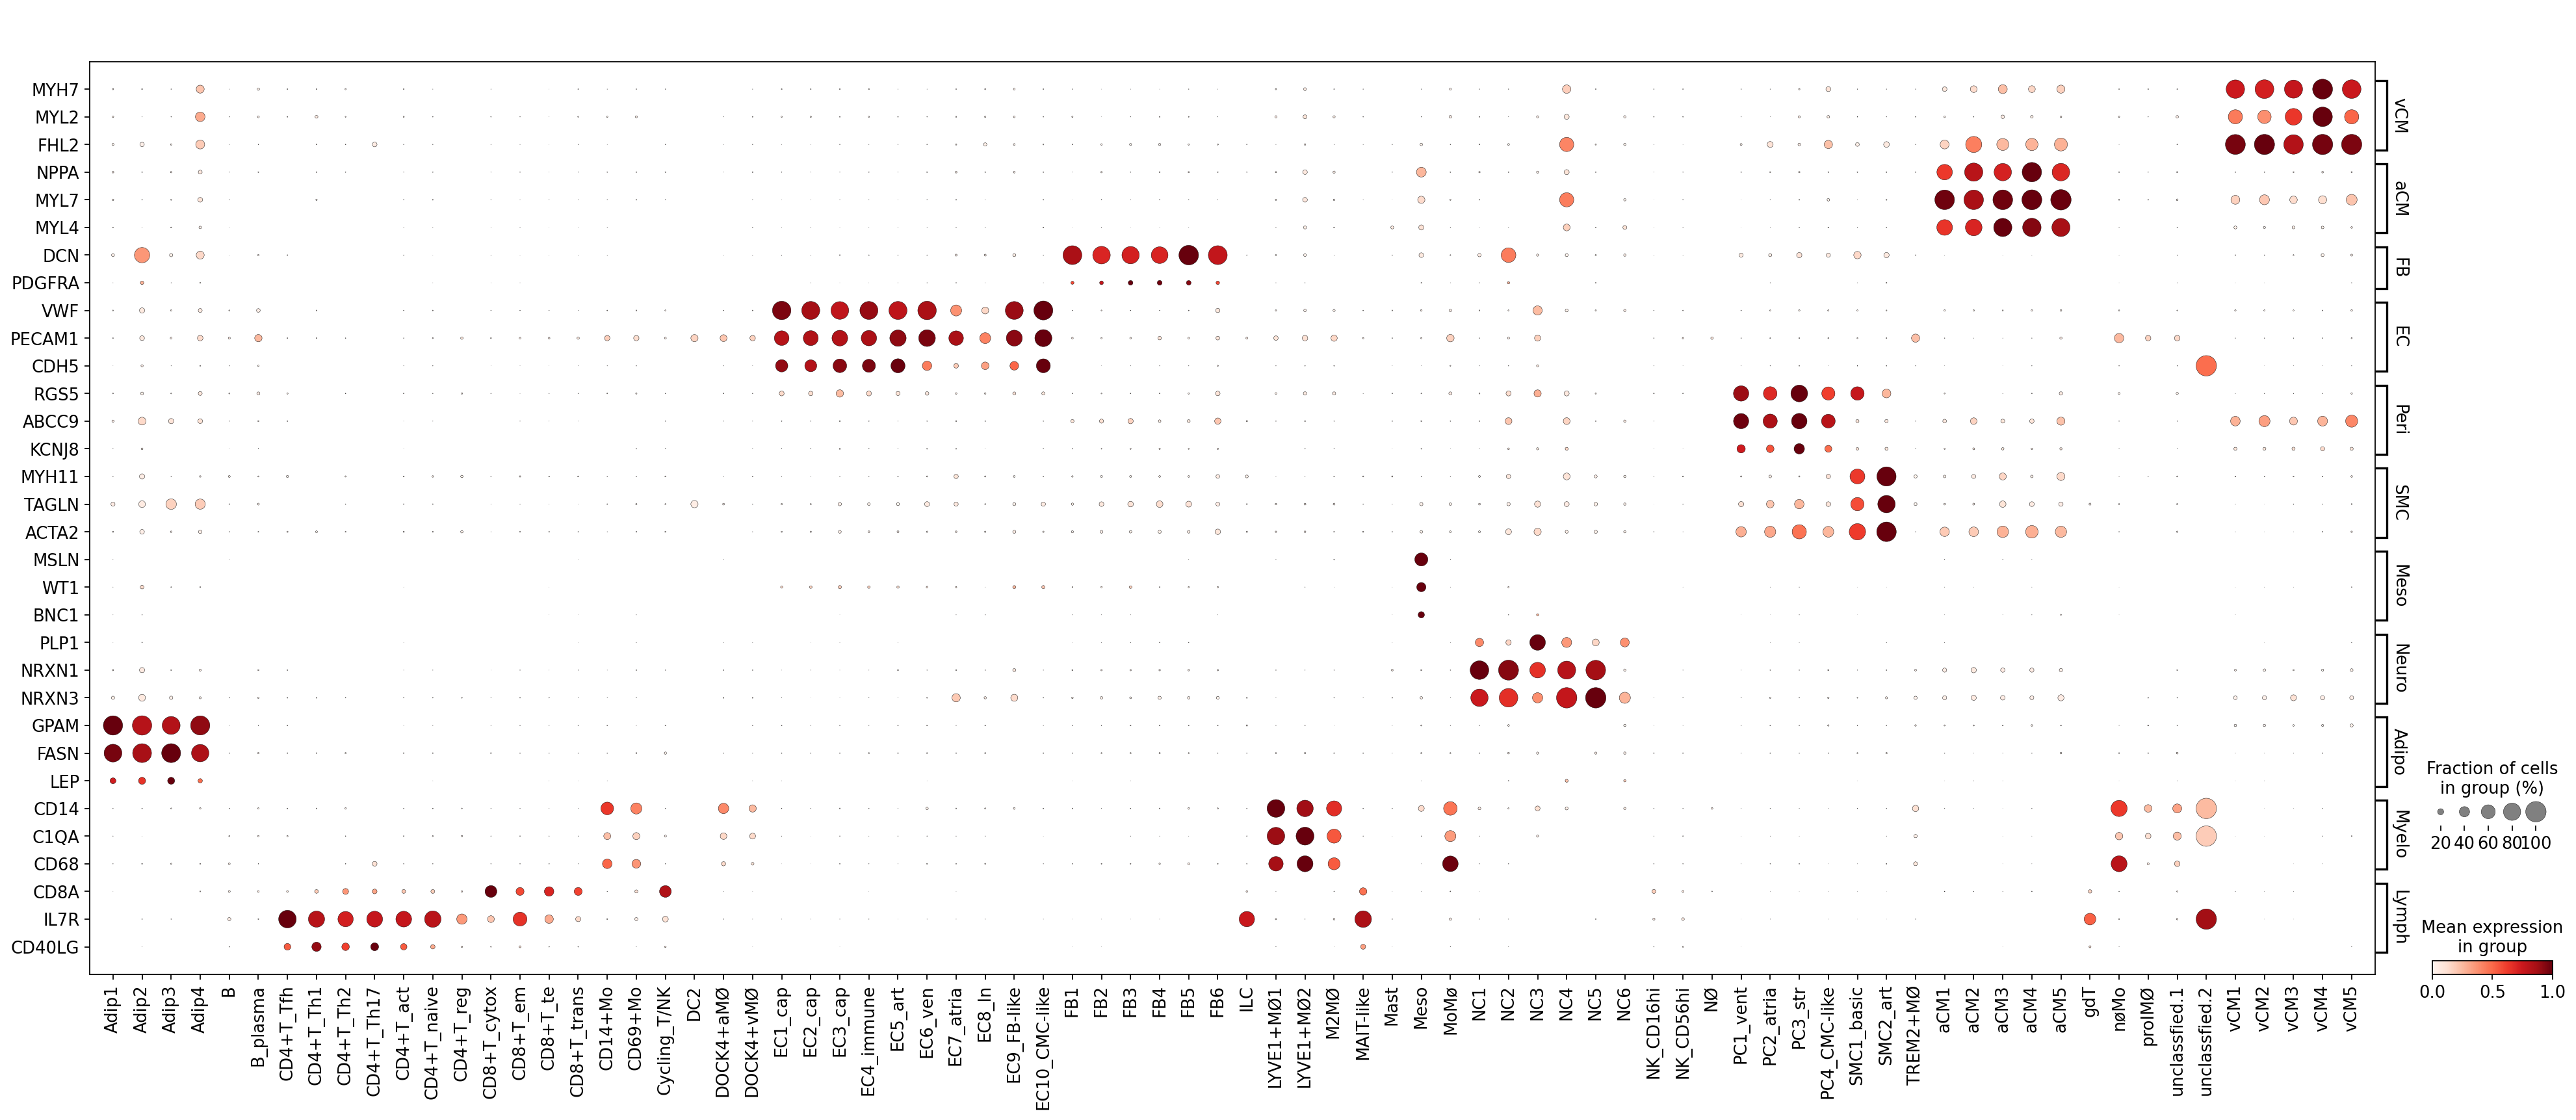

In [11]:
genename_column = 'gene_name_multiome-2'

# marker check
marker_genes_dict = {
    'vCM': ['MYH7', 'MYL2', 'FHL2'],
    'aCM': ['NPPA', 'MYL7', 'MYL4'],
    'FB': ['DCN', 'GCN', 'PDGFRA'],
    'EC': ['VWF', 'PECAM1', 'CDH5'],
    'Peri': ['RGS5', 'ABCC9', 'KCNJ8'],
    'SMC': ['MYH11', 'TAGLN', 'ACTA2'],
    'Meso': ['MSLN', 'WT1', 'BNC1'],
    'Neuro': ['PLP1', 'NRXN1', 'NRXN3'],
    'Adipo': ['GPAM', 'FASN', 'LEP'],
    'Myelo': ['CD14', 'C1QA', 'CD68'],
    'Lymph': ['CD8A', 'IL7R', 'CD40LG'],
}

for k, v in marker_genes_dict.items():
    marker_genes_dict[k] = [x for x in v if x in list(ref.var[genename_column])]
    
sc.pl.dotplot(ref, marker_genes_dict, 
              groupby='cell_state_HCAv1',
              gene_symbols=genename_column,
              dendrogram=False,
              # use_raw=True,
              standard_scale="var",
              color_map="Reds",
             swap_axes=True)

## Read in query data

In [13]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/multiome_RNA_adult_new-SAN-AVN_raw_rmdblcls.h5ad')
adata

AnnData object with n_obs × n_vars = 75255 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch_key', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'clus20', 'doublet_cls', 'cell_state_scNym', 'cell_state_scNym_confidence'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expres

In [14]:
adata.X.data[:10]

array([2., 1., 4., 2., 4., 1., 4., 2., 1., 1.], dtype=float32)

## Cell states label transfer from scnRNA to Multiome

### Train

In [12]:
%%time
scnym_api(
    adata=ref,
    task='train',
    groupby='cell_state',
    out_path='/nfs/team205/heart/scnym/model_8reg-v1-woCCS_cellstates',
    config='new_identity_discovery',
)

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

No unlabeled data was found.
Did you forget to set some examples as `"Unlabeled"`?
Proceeding with purely supervised training.

X:  (93680, 31105)
y:  (93680,)
Not weighting classes and not balancing classes.
Found 2 unique domains.
Training...
Saving best model weights..._____________|
Saved best weights.
Saving best model weights..._____________|
Saved best weights.
>>>>> 47/99|--------------________________|
Early stopping at epoch 47
>>>>>
Training complete.

Evaluating model.
EVAL LOSS:  0.7529438476304751
EVAL ACC :  0.7501067463706234
Predictions | Labels
[[58 58]
 [58 58]
 [23 25]
 [57 57]
 [43 43]
 [20 23]
 [43  7]
 [22 22]
 [25 25]
 [23 23]
 [ 7 39]
 [22 22]
 [39 37]
 [25 22]
 [39 37]]
CPU times: user 3h 52min 7s, sys: 1h 22min 4s, total: 5h 14min 12s
Wall time: 46min 19s


### Predict

In [15]:
que = adata.copy()
sc.pp.normalize_total(que, target_sum=1e4)
sc.pp.log1p(que)
que.X.data[:10]

normalizing counts per cell
    finished (0:00:00)


array([0.4168644 , 0.22999871, 0.71019775, 0.4168644 , 0.71019775,
       0.22999871, 0.71019775, 0.4168644 , 0.22999871, 0.22999871],
      dtype=float32)

In [16]:
scnym_api(
    adata=que,
    task='predict',
    key_added='cell_state_scNym',
    config='new_identity_discovery',
    trained_model='/nfs/team205/heart/scnym/model_8reg-v1-woCCS_cellstates',
)

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

Loaded model predicting 71 classes from 31105 features
['Adip1' 'Adip2' 'Adip3' 'Adip4' 'B' 'B_plasma' 'CD14+Mo' 'CD16+Mo'
 'CD4+T_Tfh' 'CD4+T_Th1' 'CD4+T_Th17' 'CD4+T_Th2' 'CD4+T_act'
 'CD4+T_naive' 'CD4+T_reg' 'CD8+T_cytox' 'CD8+T_em' 'CD8+T_te'
 'CD8+T_trans' 'DC' 'EC10_CMC-like' 'EC1_cap' 'EC2_cap' 'EC3_cap'
 'EC4_immune' 'EC5_art' 'EC6_ven' 'EC7_endocardial' 'EC8_ln' 'EC9_FB-like'
 'FB1' 'FB2' 'FB3' 'FB4_activated' 'FB5' 'FB6' 'ILC' 'LYVE1+IGF1+MP'
 'LYVE1+MP_cycling' 'LYVE1+TIMD4+MP' 'MAIT-like' 'Mast' 'Meso' 'MoMP'
 'NC1_glial' 'NC2_glial_NGF+' 'NC3_glial' 'NC4_glial' 'NC5_glial'
 'NC6_schwann' 'NK_CD16hi' 'NK_CD56hi' 'Neut' 'PC1_vent' 'PC2_atria'
 'PC3_str' 'PC4_CMC-like' 'SMC1_basic' 'SMC2_art' 'T/NK_cycling' 'aCM1'
 'aCM2' 'aCM3' 'aCM4' 'aCM5' 'gdT' 'vCM1' 'vCM2' 'vCM3_stressed' 'vCM4'
 'vCM5']
Building a classification matrix...


mapping genes: 36601it [00:39, 929.86it/s] 
Finding cell types:   0%|          | 0/74 [00:00<?, ?it/s]

Found 31105 common genes.
Predicting cell types...


Finding cell types: 100%|██████████| 74/74 [00:23<00:00,  3.18it/s]


Extracting model embeddings...


In [17]:
que.obs[['region','cell_state_scNym_confidence']].groupby('region').mean()

cell_state_scNym_confidence
region                             
AVN                        0.778064
SAN                        0.778184

... storing 'cell_state_scNym' as categorical


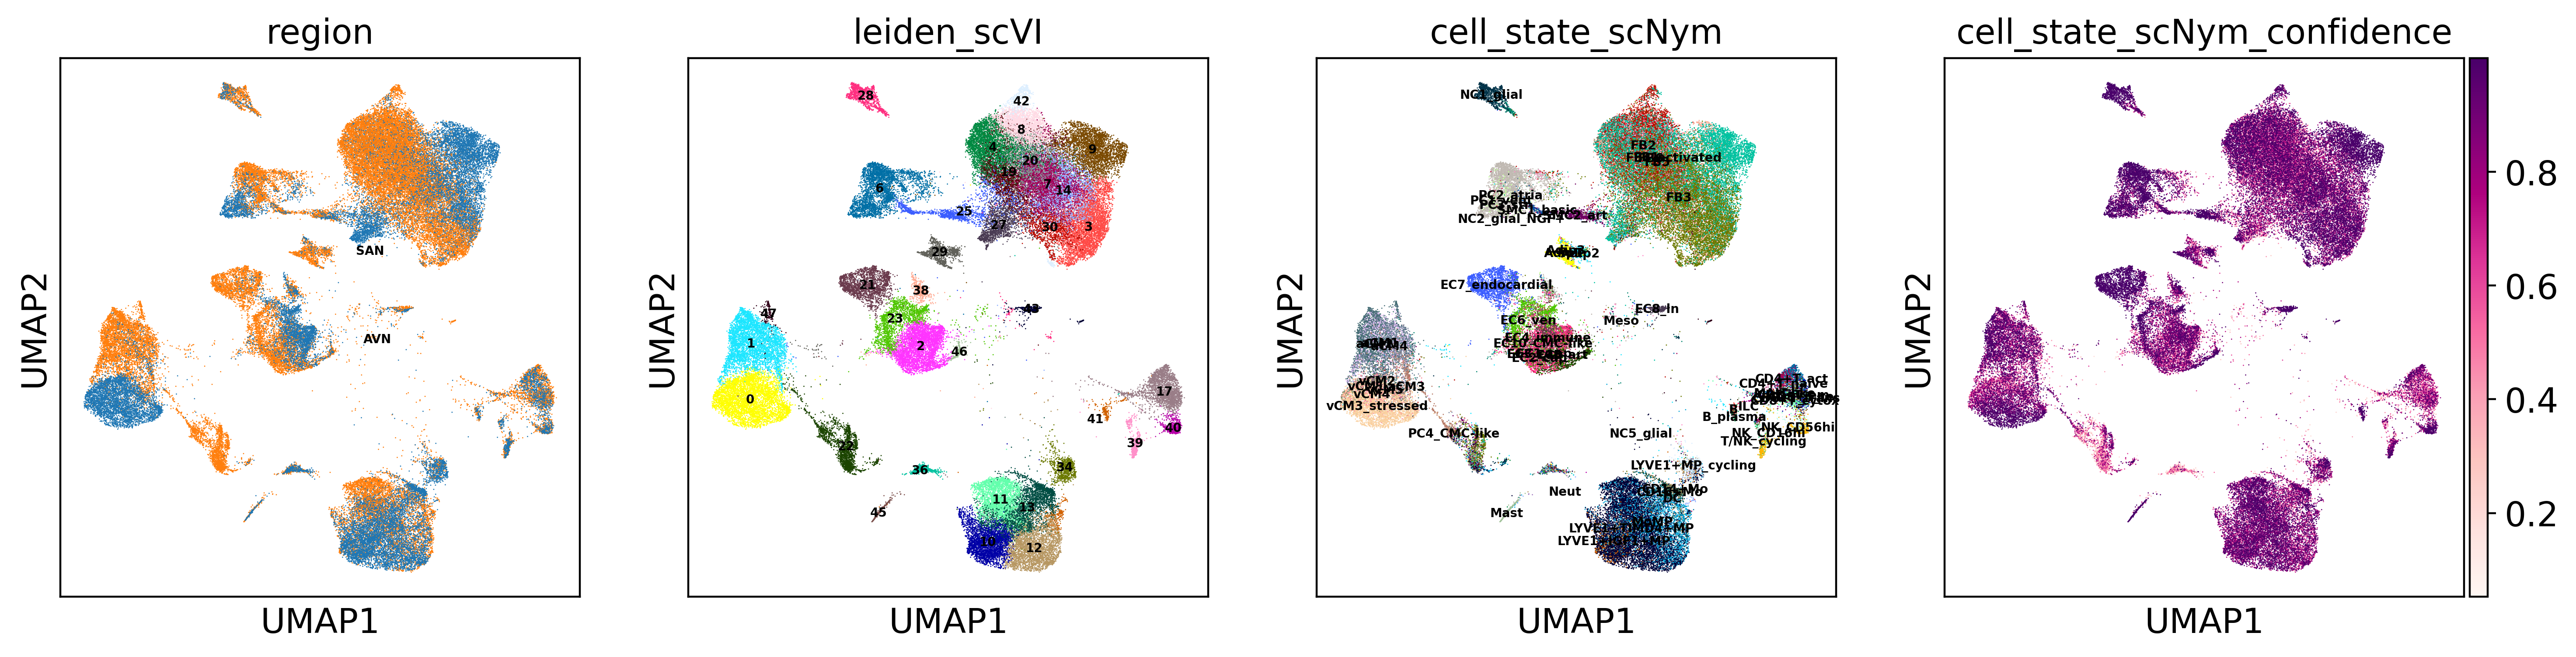

In [18]:
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',)
sc.pl.umap(que, color=['region','leiden_scVI','cell_state_scNym','cell_state_scNym_confidence'], size=1, wspace=0.1, legend_loc='on data', legend_fontsize=5)

## Add syNym output to original adata

In [20]:
df = que.obs[['cell_state_scNym','cell_state_scNym_confidence']].copy()
adata.obs[df.columns]=df.reindex(adata.obs_names)
adata.obs

latent_RT_efficiency  \
barcode                                                                    
HCAHeartST13146201_HCAHeartST13129134_TACTCAAAG...              2.765131   
HCAHeartST13146201_HCAHeartST13129134_AGCAAATAG...              2.646194   
HCAHeartST13146201_HCAHeartST13129134_TTCATTCAG...              2.670616   
HCAHeartST13146201_HCAHeartST13129134_GGTAAGGGT...              2.292701   
HCAHeartST13146201_HCAHeartST13129134_CGTTTCTCA...              2.303041   
...                                                                  ...   
HCAHeartST13180619_HCAHeartST13177116_CTTGAATCA...              0.569887   
HCAHeartST13180619_HCAHeartST13177116_AAAGCTTGT...              0.800446   
HCAHeartST13180619_HCAHeartST13177116_AATCATCCA...              0.596763   
HCAHeartST13180619_HCAHeartST13177116_AGGCTAGCA...              0.538972   
HCAHeartST13180619_HCAHeartST13177116_GCAAGTCGT...              0.840640   

                                                    latent_cell_probability  \
barcode                                                                       
HCAHeartST13146201_HCAHeartST13129134_TACTCAAAG...                 0.999997   
HCAHeartST13146201_HCAHeartST13129134_AGCAAATAG...                 0.999993   
HCAHeartST13146201_HCAHeartST13129134_TTCATTCAG...                 0.999995   
HCAHeartST13146201_HCAHeartST13129134_GGTAAGGGT...                 0.999996   
HCAHeartST13146201_HCAHeartST13129134_CGTTTCTCA...                 0.999961   
...                                                                     ...   
HCAHeartST13180619_HCAHeartST13177116_CTTGAATCA...                 0.992373   
HCAHeartST13180619_HCAHeartST13177116_AAAGCTTGT...                 0.997721   
HCAHeartST13180619_HCAHeartST13177116_AATCATCCA...                 0.995069   
HCAHeartST13180619_HCAHeartST13177116_AGGCTAGCA...                 0.996163   
HCAHeartST13180619_HCAHeartST13177116_GCAAGTCGT...                 0.985555   

                                                    latent_scale  \
barcode                                                            
HCAHeartST13146201_HCAHeartST13129134_TACTCAAAG...  12380.899414   
HCAHeartST13146201_HCAHeartST13129134_AGCAAATAG...  11970.831055   
HCAHeartST13146201_HCAHeartST13129134_TTCATTCAG...  11972.784180   
HCAHeartST13146201_HCAHeartST13129134_GGTAAGGGT...  10362.084961   
HCAHeartST13146201_HCAHeartST13129134_CGTTTCTCA...  10122.751953   
...                                                          ...   
HCAHeartST13180619_HCAHeartST13177116_CTTGAATCA...   4615.056641   
HCAHeartST13180619_HCAHeartST13177116_AAAGCTTGT...   4723.684082   
HCAHeartST13180619_HCAHeartST13177116_AATCATCCA...   4700.160156   
HCAHeartST13180619_HCAHeartST13177116_AGGCTAGCA...   4439.463379   
HCAHeartST13180619_HCAHeartST13177116_GCAAGTCGT...   4449.288086   

                                                              sangerID  \
barcode                                                                  
HCAHeartST13146201_HCAHeartST13129134_TACTCAAAG...  HCAHeartST13146201   
HCAHeartST13146201_HCAHeartST13129134_AGCAAATAG...  HCAHeartST13146201   
HCAHeartST13146201_HCAHeartST13129134_TTCATTCAG...  HCAHeartST13146201   
HCAHeartST13146201_HCAHeartST13129134_GGTAAGGGT...  HCAHeartST13146201   
HCAHeartST13146201_HCAHeartST13129134_CGTTTCTCA...  HCAHeartST13146201   
...                                                                ...   
HCAHeartST13180619_HCAHeartST13177116_CTTGAATCA...  HCAHeartST13180619   
HCAHeartST13180619_HCAHeartST13177116_AAAGCTTGT...  HCAHeartST13180619   
HCAHeartST13180619_HCAHeartST13177116_AATCATCCA...  HCAHeartST13180619   
HCAHeartST13180619_HCAHeartST13177116_AGGCTAGCA...  HCAHeartST13180619   
HCAHeartST13180619_HCAHeartST13177116_GCAAGTCGT...  HCAHeartST13180619   

                                                                               combinedID  \
barcode                                                                                     
H

In [21]:
adata.write('/nfs/team205/heart/anndata_objects/8regions/multiome_RNA_adult_new-SAN-AVN_raw_rmdblcls.h5ad')

In [22]:
adata.X.data[:10]

array([2., 1., 4., 2., 4., 1., 4., 2., 1., 1.], dtype=float32)

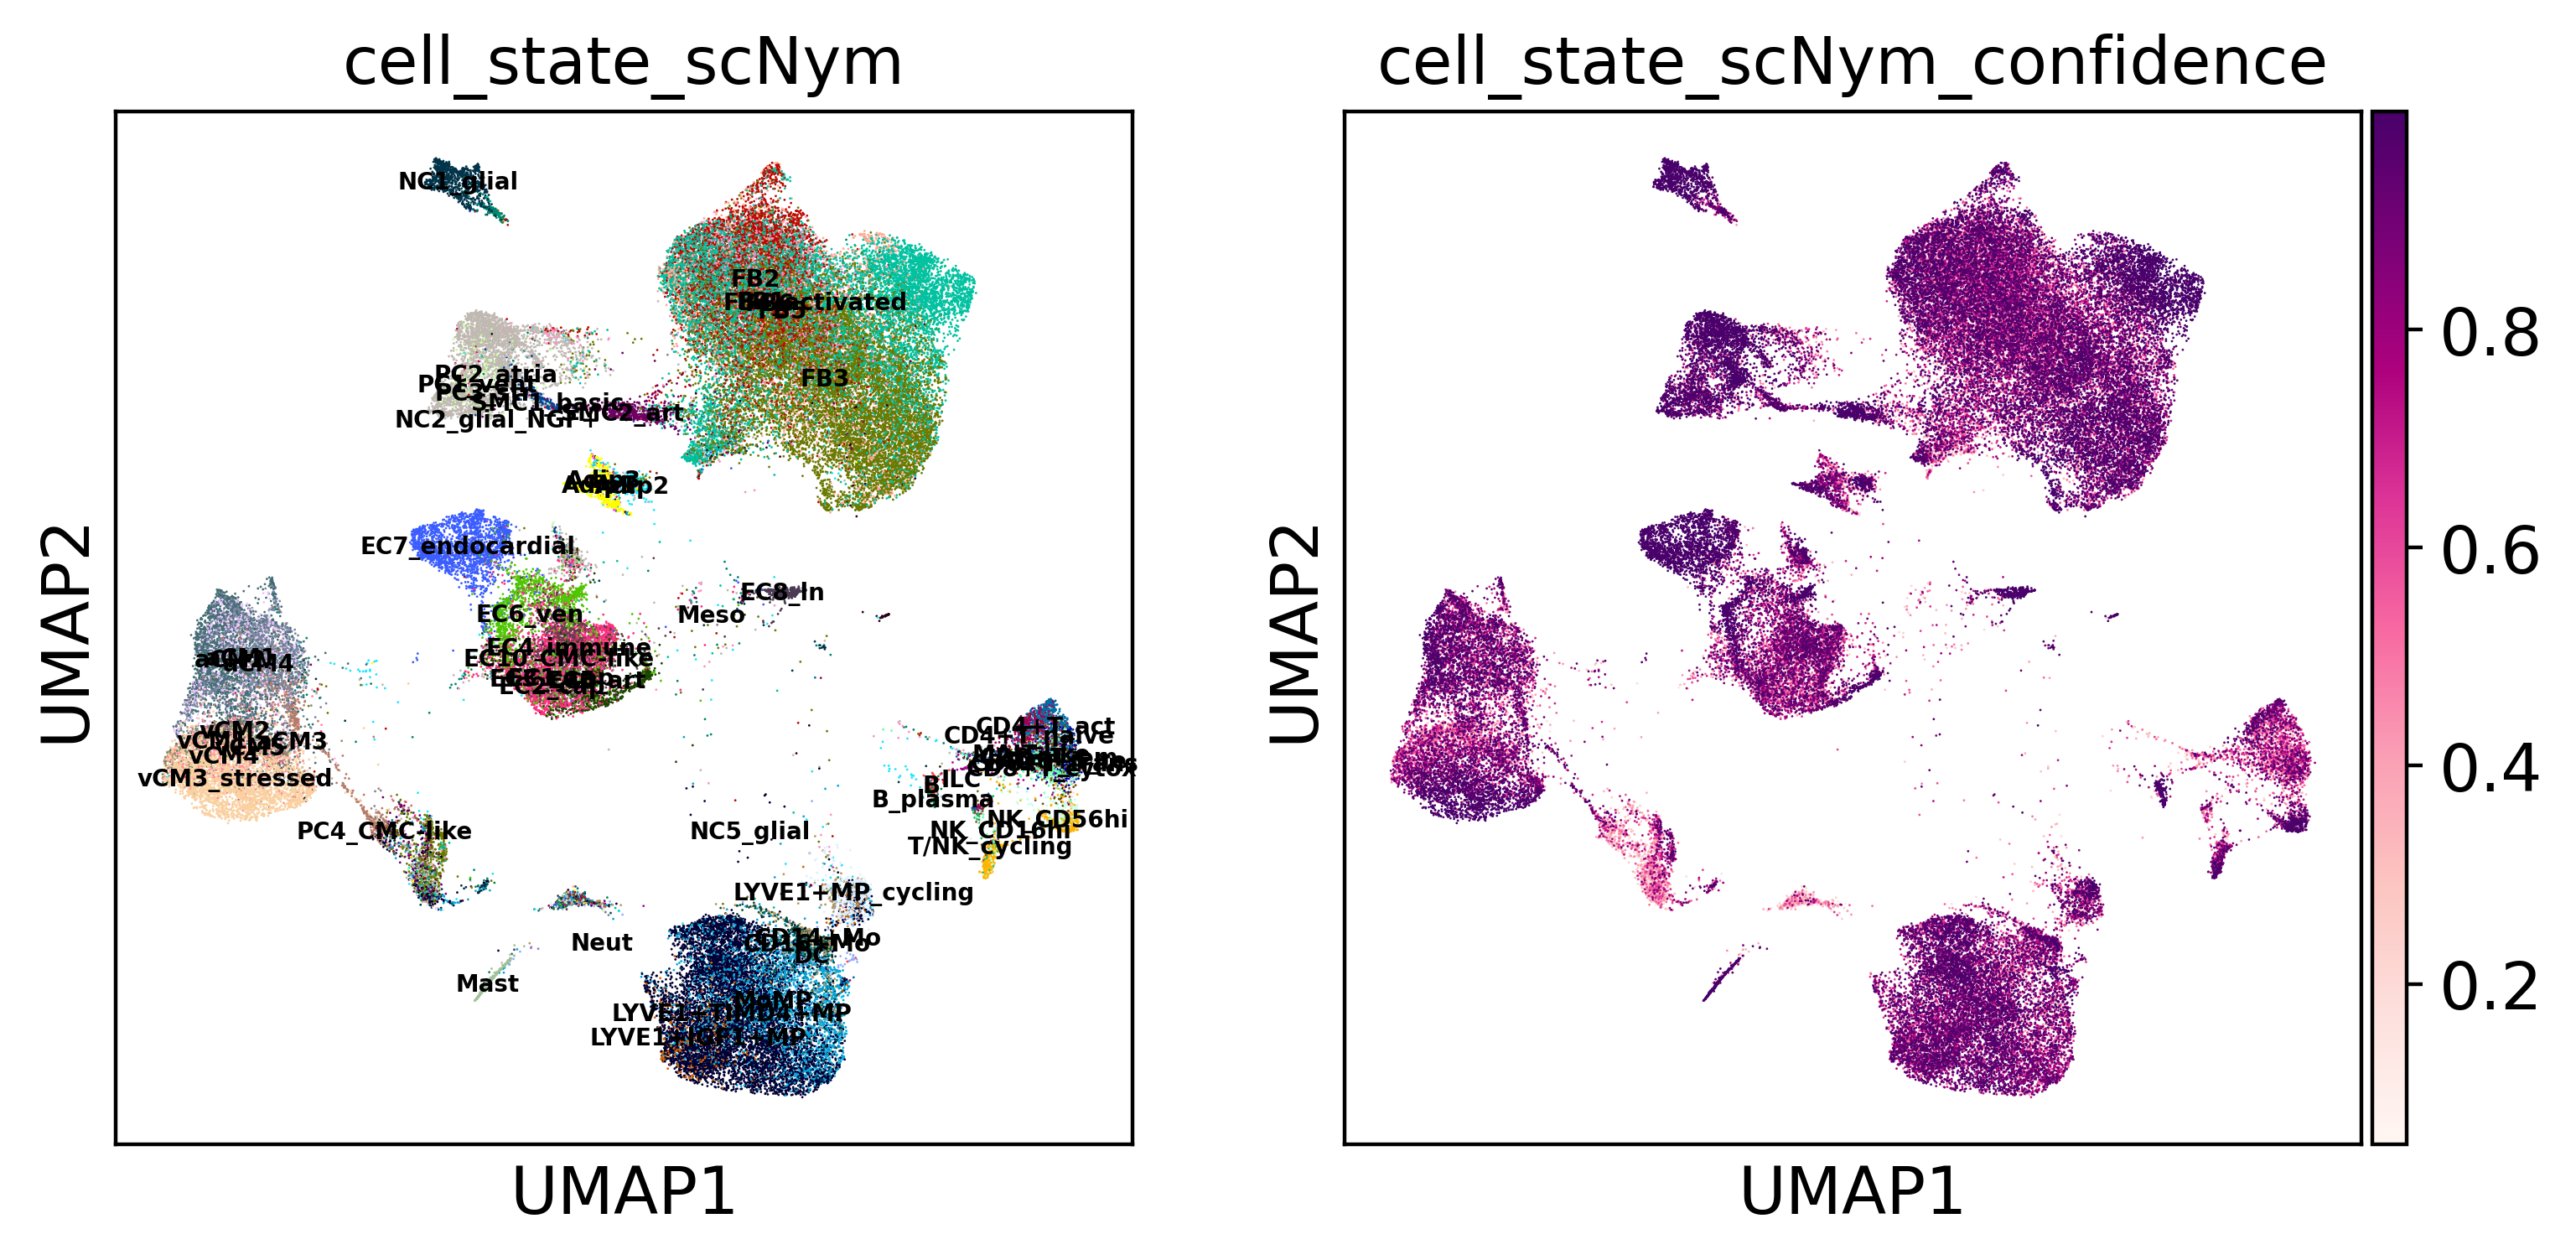

In [23]:
sc.pl.umap(adata, color=['cell_state_scNym','cell_state_scNym_confidence'], size=1, wspace=0.1, legend_loc='on data', legend_fontsize=5)

## Checking marker expressions

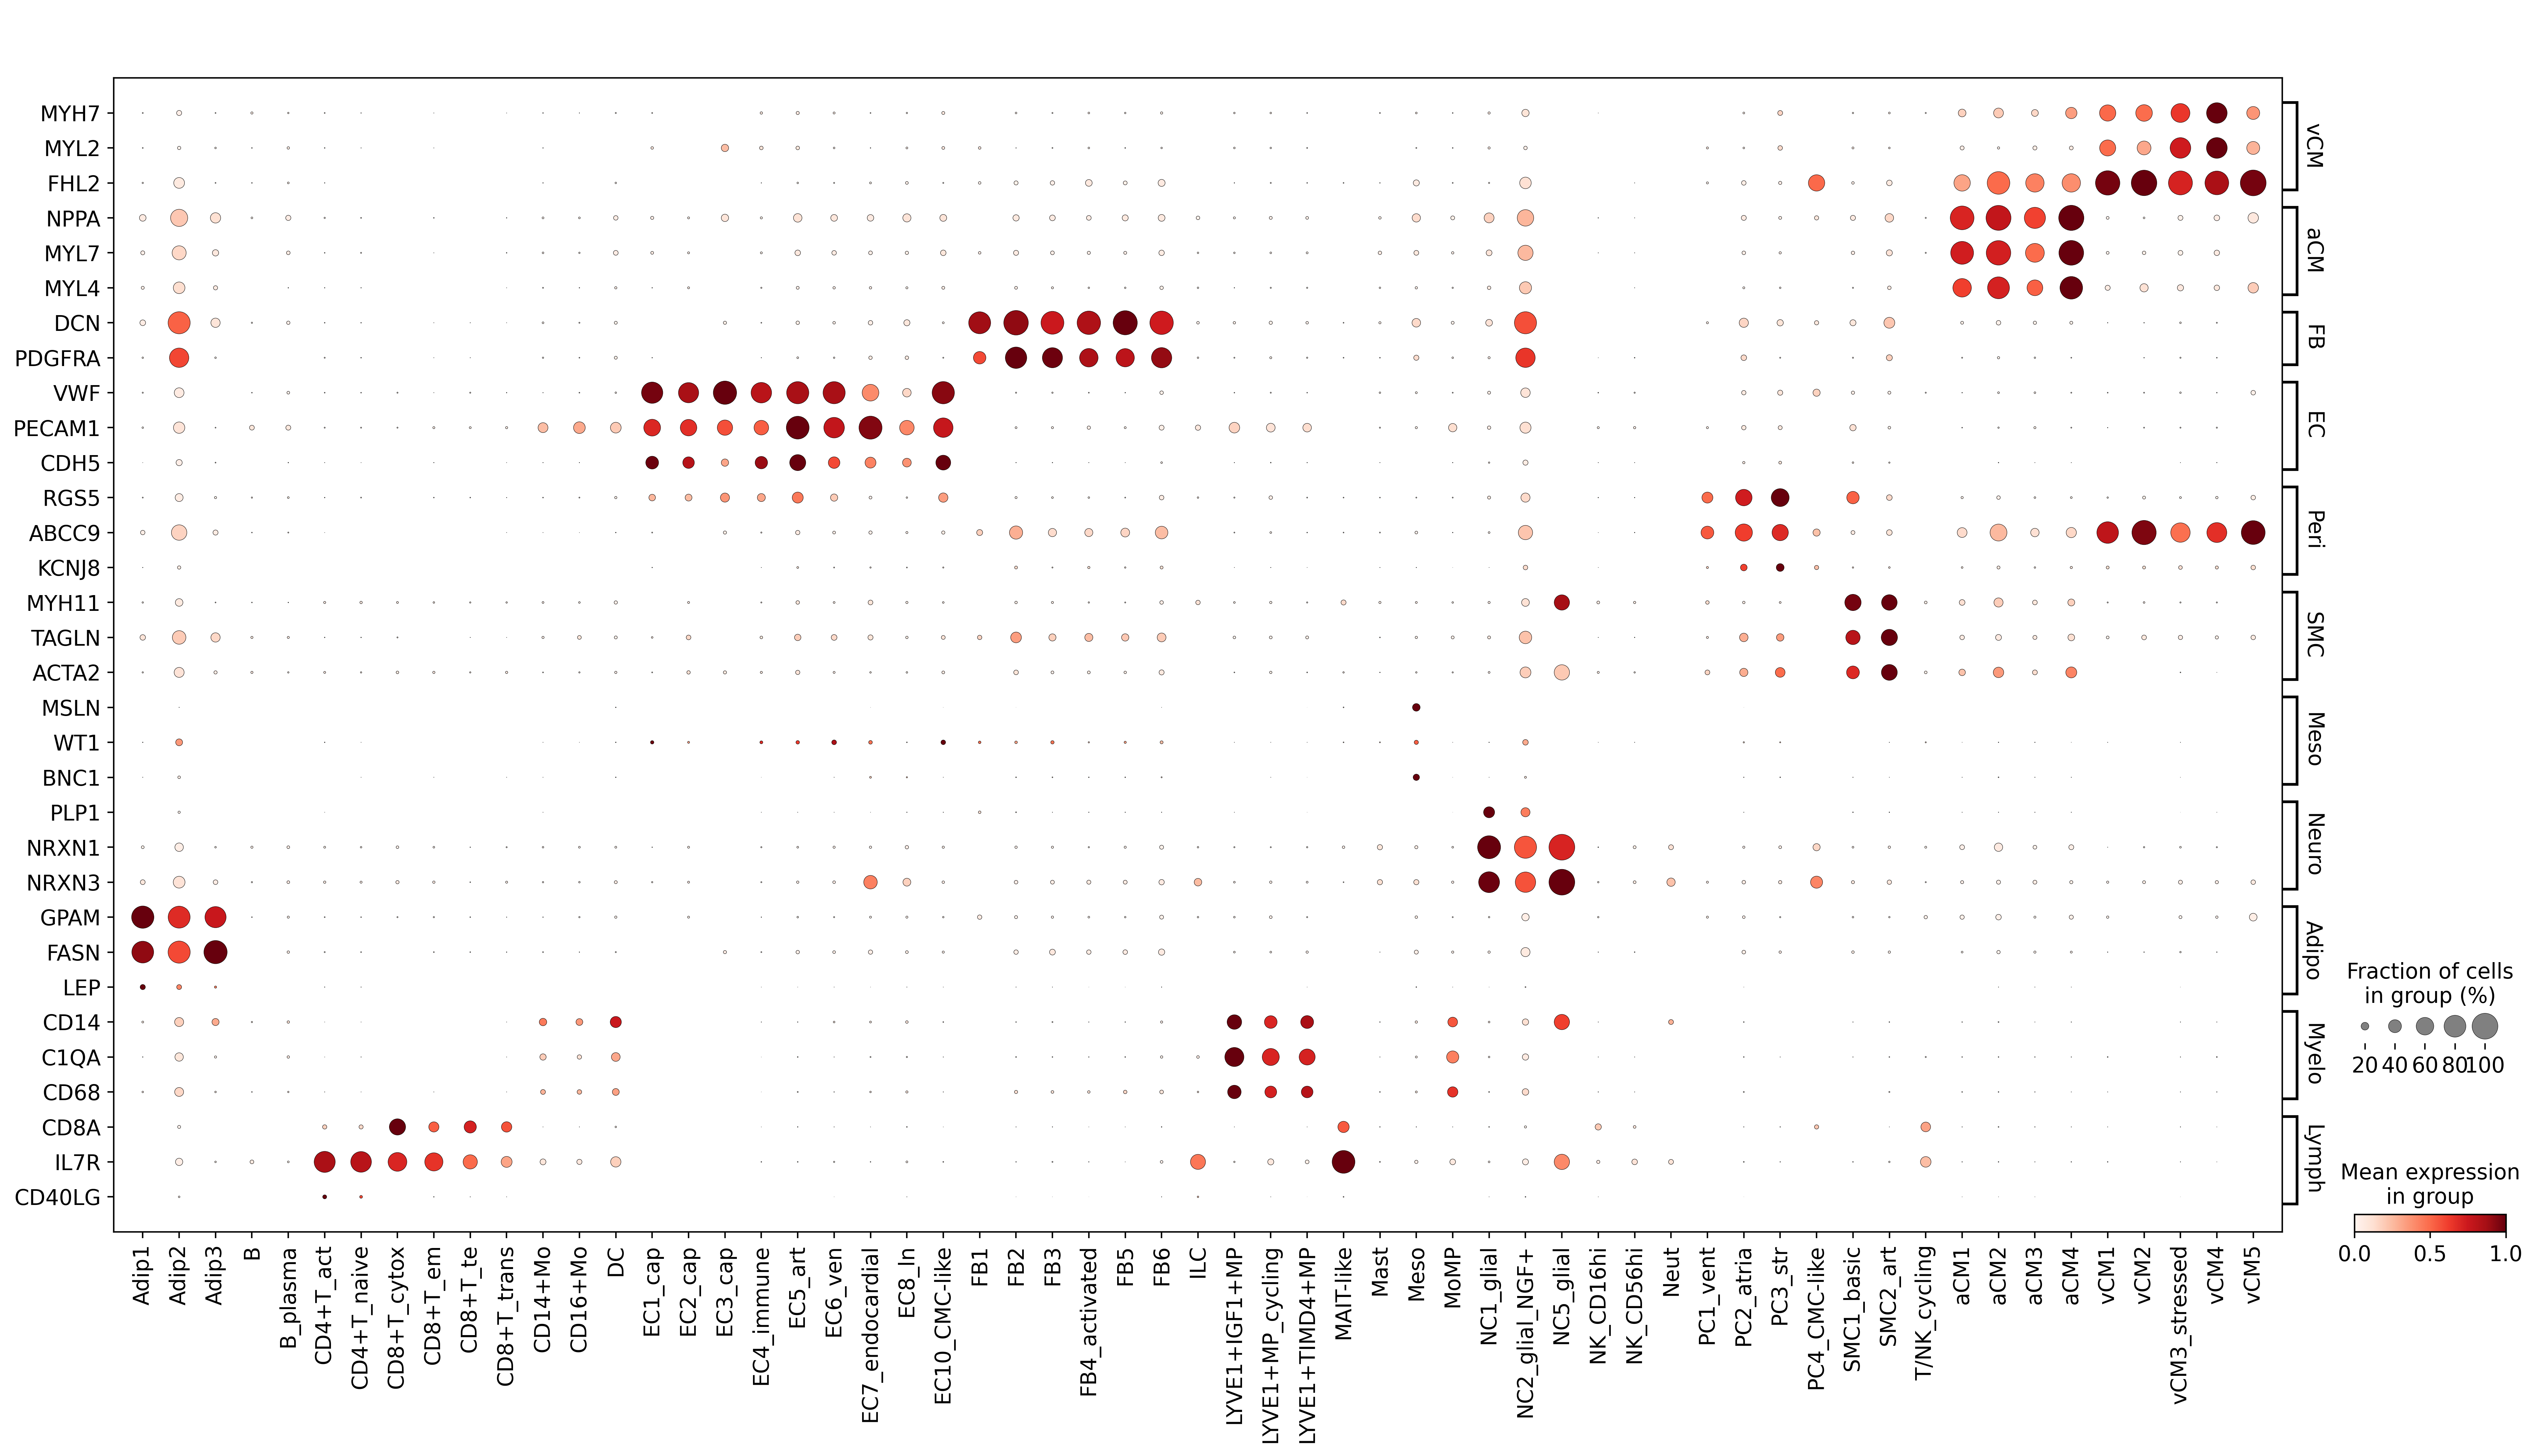

In [24]:
genename_column = 'gene_name'

# sanity check
marker_genes_dict = {
    'vCM': ['MYH7', 'MYL2', 'FHL2'],
    'aCM': ['NPPA', 'MYL7', 'MYL4'],
    'FB': ['DCN', 'GCN', 'PDGFRA'],
    'EC': ['VWF', 'PECAM1', 'CDH5'],
    'Peri': ['RGS5', 'ABCC9', 'KCNJ8'],
    'SMC': ['MYH11', 'TAGLN', 'ACTA2'],
    'Meso': ['MSLN', 'WT1', 'BNC1'],
    'Neuro': ['PLP1', 'NRXN1', 'NRXN3'],
    'Adipo': ['GPAM', 'FASN', 'LEP'],
    'Myelo': ['CD14', 'C1QA', 'CD68'],
    'Lymph': ['CD8A', 'IL7R', 'CD40LG'],
}

for k, v in marker_genes_dict.items():
    marker_genes_dict[k] = [x for x in v if x in list(que.var[genename_column])]
    
sc.pl.dotplot(que, marker_genes_dict, 
              groupby='cell_state_scNym',
              gene_symbols=genename_column,
              dendrogram=False,
              # use_raw=True,
              standard_scale="var",
              color_map="Reds",
             swap_axes=True)